In [9]:
from pylab import imshow, figure, plot, colorbar, show, hist
%matplotlib inline

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [5]:
import data
import datagen
import net
import scipy.ndimage.interpolation
import numpy as np
import pandas as pd
import pickle

df = data.ndsb17_get_df_test_labels()

p_base = len(df[df["cancer"]==1]) / len(df)
c, nc = [], []
y_true, y_pred = [], []
for n in range(len(df)):
    pid = df["id"][n]
    print(pid, df["cancer"][n])
    y_true.append(df["cancer"][n])
    
    with open('/mnt/data/ndsb17/predict/' + pid + '.pkl', 'rb') as fh:
        label_boxes, label_sizes, label_activities_sum, label_activities_max = pickle.load( fh )

    for idx in np.argsort(label_activities_sum)[::-1][:5]:
        print(idx, label_boxes[idx], label_sizes[idx], label_activities_sum[idx])
    
    for idx in np.argsort(label_activities_sum)[::-1][:1]:
        if df["cancer"][n] == 1:
            c.append(label_activities_sum[idx])
        else:
            nc.append(label_activities_sum[idx])

    idx = np.argsort(label_activities_sum)[::-1][:1]
    top_act = label_activities_sum[idx]
    if top_act < 50:
        p_pred = p_base*0.35
    elif top_act < 50:
        p_pred = p_base*1.3
    elif top_act < 300:
        p_pred = p_base*1.5
    else:
        p_pred = p_base*2
    y_pred.append( 0.6*p_pred + 0.4*p_base )
        
#     image = data.ndsb17_get_image(pid)
#     segmented_image = data.ndsb17_get_segmented_image(pid)
#     image = datagen.preprocess(image)

#     image_2mm = scipy.ndimage.interpolation.zoom(image, (0.5, 0.5, 0.5), order=1)
#     segmented_image_2mm = scipy.ndimage.interpolation.zoom(segmented_image.astype(np.float32), (0.5, 0.5, 0.5), order=1)
#     segmented_image_2mm = (segmented_image_2mm > 0)

#     predicted_image = net.tiled_predict(volume_model, image_2mm)[:,:,:,1]
#     np.save('/mnt/data/ndsb17/predict/' + pid + '.npy', predicted_image)

#     predicted_image *= segmented_image_2mm



/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


026470d51482c93efc18b9803159c960 1.0
17 (slice(142, 146, None), slice(124, 129, None), slice(75, 80, None)) 40.0 111.587815762
2 (slice(58, 61, None), slice(128, 131, None), slice(62, 65, None)) 14.0 33.5739893913
13 (slice(116, 119, None), slice(101, 104, None), slice(77, 80, None)) 11.0 26.2523629665
4 (slice(75, 78, None), slice(112, 113, None), slice(65, 68, None)) 8.0 21.695884943
5 (slice(83, 85, None), slice(81, 83, None), slice(69, 71, None)) 7.0 17.3322179317
031b7ec4fe96a3b035a8196264a8c8c3 1.0
5 (slice(43, 48, None), slice(48, 52, None), slice(155, 159, None)) 26.0 64.2092003822
24 (slice(82, 85, None), slice(138, 142, None), slice(69, 72, None)) 18.0 46.7658338547
11 (slice(57, 60, None), slice(97, 102, None), slice(28, 33, None)) 16.0 36.1884875298
26 (slice(84, 87, None), slice(147, 151, None), slice(61, 64, None)) 14.0 35.3328819275
30 (slice(91, 94, None), slice(143, 146, None), slice(68, 70, None)) 10.0 24.839155674
03bd22ed5858039af223c04993e9eb22 0.0
2 (slice(75, 79,

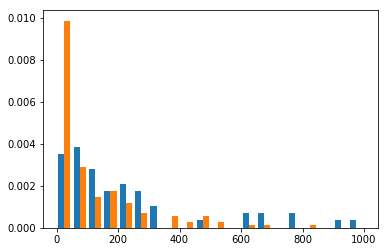

In [20]:
h = hist((c,nc), range=(0,1000), bins=20, normed=True)

In [92]:
import sklearn.metrics

In [32]:
sklearn.metrics.log_loss(y_true, y_pred)

0.55480434473829121

In [1]:
from keras.models import Model
import net
import numpy as np

Using TensorFlow backend.


In [2]:
model = net.model3d((16, 16, 16), do_features=True)
model.load_weights('tmp2c.h5')

In [3]:
# model.layers.pop()
# model.layers.pop()
# model.outputs = [model.layers[-1].output]
# model.output_layers = [model.layers[-1]]
# model.layers[-1].outbound_nodes = []

In [3]:
model2 = Model(input=model.input, output=model.layers[-2].output)

In [6]:
vsize = np.asarray([32,32,32])
df_nodes = data.ndsb17_get_df_nodes() 
df_nodes = df_nodes[(df_nodes["diameter_mm"]>10)]
X_nodules, diams = data.ndsb17_get_all_nodules(vsize, df_nodes)

b8dc33b670bb078d10954345c3ffbb3a FileNotFoundError(2, 'No such file or directory')


In [4]:
model2.predict(np.zeros((1,16,16,16,1), dtype=np.float32)).shape

(1, 1, 1, 1, 243)

In [12]:
y_true = []
features = []
for n in range(len(df)):
    pid = df["id"][n]
    print(pid)

    with open('/mnt/data/ndsb17/predict/' + pid + '.pkl', 'rb') as fh:
        label_boxes, label_sizes, label_activities_sum, label_activities_max = pickle.load( fh )

    idx = np.argsort(label_activities_sum)[::-1][:1]
    box = label_boxes[idx]
    if box is None:
        continue
    
    center = 2*np.asarray([(box[0].start+box[0].stop)//2, (box[1].start+box[1].stop)//2, (box[2].start+box[2].stop)//2 ])
    
    image = data.ndsb17_get_image(pid)
    # segmented_image = data.ndsb17_get_segmented_image(pid)
    # image = datagen.preprocess(image)
    # image_2mm = scipy.ndimage.interpolation.zoom(image, (0.5, 0.5, 0.5), order=1)
    # segmented_image_2mm = scipy.ndimage.interpolation.zoom(segmented_image.astype(np.float32), (0.5, 0.5, 0.5), order=1)
    # segmented_image_2mm = (segmented_image_2mm > 0)

    volume = image[center[0]-16:center[0]+16, center[1]-16:center[1]+16, center[2]-16:center[2]+16 ]
    volume = scipy.ndimage.interpolation.zoom(volume, (0.5, 0.5, 0.5), order=1)
    volume = datagen.preprocess(volume)
    if volume.shape != (16,16,16):
        continue

    feat = model2.predict(volume[None,:,:,:,None], batch_size=1)
    features.append(feat.ravel())
    y_true.append(df["cancer"][n])


026470d51482c93efc18b9803159c960
031b7ec4fe96a3b035a8196264a8c8c3
03bd22ed5858039af223c04993e9eb22
06a90409e4fcea3e634748b967993531
07b1defcfae5873ee1f03c90255eb170
0b20184e0cd497028bdd155d9fb42dc9
12db1ea8336eafaf7f9e3eda2b4e4fef
159bc8821a2dc39a1e770cb3559e098d
174c5f7c33ca31443208ef873b9477e5
1753250dab5fc81bab8280df13309733
1cf8e778167d20bf769669b4be96592b
1e62be2c3b6430b78ce31a8f023531ac
1f6333bc3599f683403d6f0884aefe00
1fdbc07019192de4a114e090389c8330
2004b3f761c3f5dffb02204f1247b211
202898fa97c5949fbdc07ae7ff1cd9f0
21b73c938fd7d346ee77a60bd60aaeac
243038f7bb7787497c59bc17f04c6ed9
26142353f46d20c9fdded93f01e2bff4
263a1c3bfa43556623e75ed901e3fd8f
2703df8c469906a06a45c0d7ff501199
2a3e6ecf9499607ef4fd14b436136b0c


/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


2d596b6ead89ab35577fe625a9a17cbb
2eb92d17ca91b393765e8acf069763a6
2f77fd993fbd858dec3c085b9ff1a3a2
3295cec04482210dc6f78c2b4a1d287b
33387bea2cacf6127035cc7033036a02
34037914ceeec5605fc890159dd425c5
38bf066bba822584e14c0af65d4bb5e9
3ee1fd6a0f3f108c3558e6699fb011f2
42b2161e43b4dd0ea94604485976c59c
4434e19303b62ebaecef2596583ff351
4575fe61bf3f536ce6cfeb26fcc2893c
48ab0b98fc7789304c21430978624f32
49433c1588cc078b825a0eff1dc2e816
49c88f7cc77341c9ae4e64243f9912fc
4b28f147cb82baba3edcdbd34ca19085
505405b3e70fb24b92e6a8a5b7ed339c
50cdacec399071cf70d8badd2511d0b3
519ad4ead3e61d2d71088ac8e46f25b6
52f6d741e674f62fbcf73e6ec4f6a472
538543b57d0c8fa0b2b6bb7c84df3f33
5451203688c930484ba1f3c7f1378847
55b06d60e7c0329787f81d1b7cbf9aa0
567547810a1795b9c8e11c15dfd32c34
5791c42d317f34592be9a933c50e68ad
580cffecce8d3d53cde1abb922adf21a
59af702c21840ec18073b6b56c95e7fe
5a42f0a0d1e060531c20d04ed23efc02
5ae9ab473d59cd29262c47a741177b6e
5ce91933688cc8400105bf640ac11535
5d16819bd78c74448ce852a93bf423ad
61017c23bb

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier


In [22]:
X = np.stack(features)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=.2)

In [81]:
from xgboost import XGBClassifier

In [111]:
#clf = KNeighborsClassifier(5)
clf = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
#clf = GaussianNB()
#clf = XGBClassifier()
#clf = MLPClassifier(alpha=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [112]:
score

0.71794871794871795

In [113]:
y_pred = clf.predict_proba(X_test)

In [114]:
list(zip(y_test, y_pred[:,1]))

[(1.0, 0.16804270101704333),
 (0.0, 0.43290538052283978),
 (0.0, 0.25753349561563255),
 (1.0, 0.23634049864267581),
 (0.0, 0.30328916808127815),
 (0.0, 0.24007608977257178),
 (0.0, 0.34119317832158913),
 (0.0, 0.18940328914038673),
 (0.0, 0.29346943353249344),
 (1.0, 0.14096566061698468),
 (0.0, 0.23008840005354614),
 (0.0, 0.12646340280559798),
 (1.0, 0.54644576302338521),
 (1.0, 0.53806439044232945),
 (0.0, 0.504148667209531),
 (0.0, 0.26159914513226568),
 (0.0, 0.2434753430757155),
 (0.0, 0.16617288877171177),
 (1.0, 0.22798184004955147),
 (0.0, 0.27875769368569081),
 (0.0, 0.29429176519028033),
 (0.0, 0.63662414451135874),
 (1.0, 0.53045472934110904),
 (0.0, 0.27613252588406567),
 (1.0, 0.46993425479951867),
 (0.0, 0.1995054965232157),
 (0.0, 0.53659529384054849),
 (1.0, 0.53483549144151254),
 (0.0, 0.31769780006072779),
 (1.0, 0.15387112574262574),
 (0.0, 0.21647788426366787),
 (0.0, 0.25206890429188888),
 (0.0, 0.15886010783378879),
 (1.0, 0.31321369157325307),
 (0.0, 0.148041965

In [115]:
np.mean(y_pred[:,1])

0.30443429357400287

In [89]:
p_base = len(df[df["cancer"]==1]) / len(df)

In [90]:
p_base

0.2878787878787879

In [116]:
sklearn.metrics.log_loss(y_test, y_pred[:,1]*0.3 + p_base*0.7)

0.59785530074558602